## Comparing performance of CBF algorithms - Prediction Accuracy

In this exercise we will compare 2 different algorithms of collaborative filtering and compare their performances using prediction accuracy evaluation metrics. The algorithms we will compare are - 

 - **User - User** based recommendation
 - **Item - Item** based recommendation
 
The metrics we will use to compare these algorithms are - 

#### Prediction Accuracy based metrics
 
 - **RMSE** (root mean squared error) between predicted rating and actual rating
 - **MAE** (mean absolute error) between predicted rating and actual rating

The datasets available for this exercise are as follows:

 - **movies**  : This dataset has the movieId and the name and details of all the movies in the database.
 - **ratings** : This dataset has the ratings given by each userId to the movieId they have seen.

In [1]:
# import key libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import gc
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as cs

%matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

# import datasets

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [2]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [4]:
# Get basic information about the datasets

print movies.shape, ratings.shape
print 'Unique movies : ', movies['movieId'].nunique()
print 'Unique users in ratings data : ', ratings['userId'].nunique()
print 'Unique movies in ratings data : ', ratings['movieId'].nunique()

(2500, 3) (264505, 4)
Unique movies :  2500
Unique users in ratings data :  862
Unique movies in ratings data :  2500


### I. Divide the ratings data in Test & Train dataset

We will divide the ratings dataset into two groups - train (80%) & test (20%).

The division will be done on user level. So 80% users will be in train and 20% in test. However, we will also keep some rating from test users in training dataset when we want to get their prediction.

In [5]:
all_users = ratings['userId'].unique()
print "Number of unique users in RATINGS data : ", all_users.shape[0]

np.random.seed(123)
idx = np.random.rand(len(all_users)) < 0.8
train_users = all_users[idx]
test_users = all_users[~idx]

ratings_test = ratings[ratings['userId'].isin(test_users)].reset_index(drop=True)
ratings_train = ratings[ratings['userId'].isin(train_users)].reset_index(drop=True)

print "Number of unique users in TEST data : ", ratings_test['userId'].nunique()
print "Number of unique users in TRAIN data : ", ratings_train['userId'].nunique()
print ratings.shape, ratings_test.shape, ratings_train.shape

Number of unique users in RATINGS data :  862
Number of unique users in TEST data :  181
Number of unique users in TRAIN data :  681
(264505, 4) (55270, 4) (209235, 4)


Number of movies in training dataset :  2500
Number of movies in test dataset :  2496


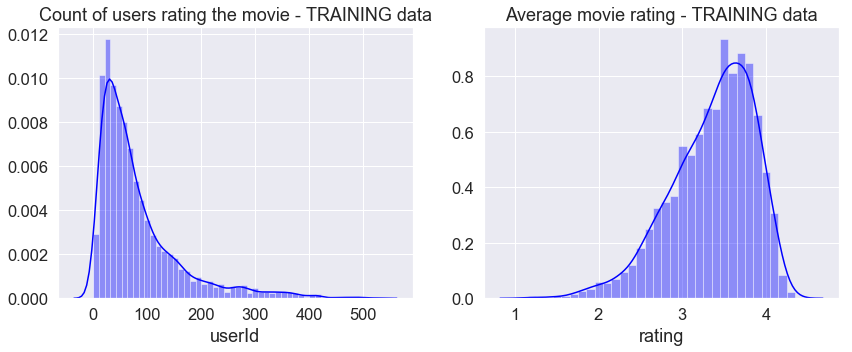

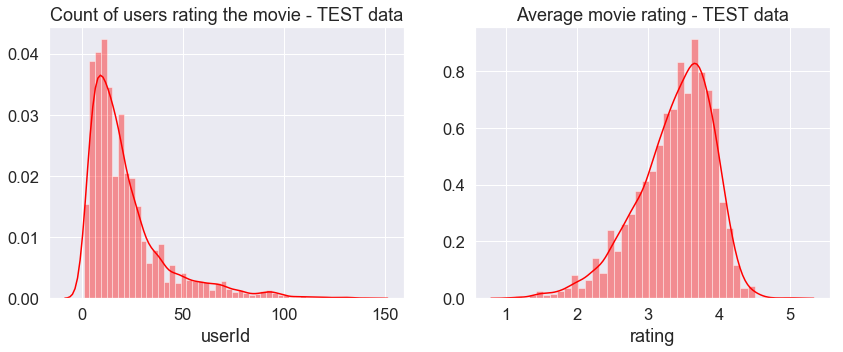

In [6]:
# checking the distributions of number of users who rated each movie and the average rating per movie
# in both test and training datasets to see any major differences

train_movie_avg = ratings_train.groupby(by='movieId', as_index=False).agg({'userId':'count', 'rating':'mean'})\
                    .reset_index(drop=True)
test_movie_avg = ratings_test.groupby(by='movieId', as_index=False).agg({'userId':'count', 'rating':'mean'})\
                    .reset_index(drop=True)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.distplot(train_movie_avg['userId'], color='blue', ax=ax1)\
    .set_title("Count of users rating the movie - TRAINING data")
sns.distplot(train_movie_avg['rating'], color='blue', ax=ax2)\
    .set_title("Average movie rating - TRAINING data")

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.distplot(test_movie_avg['userId'], color='red', ax=ax1)\
    .set_title("Count of users rating the movie - TEST data")
sns.distplot(test_movie_avg['rating'], color='red', ax=ax2)\
    .set_title("Average movie rating - TEST data")

print "Number of movies in training dataset : ", ratings_train['movieId'].nunique()
print "Number of movies in test dataset : ", ratings_test['movieId'].nunique()

Text(0.5,1,'Average movie rating - TEST data')

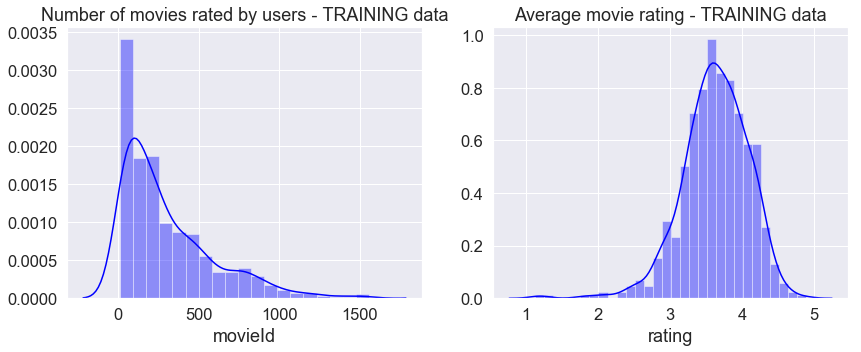

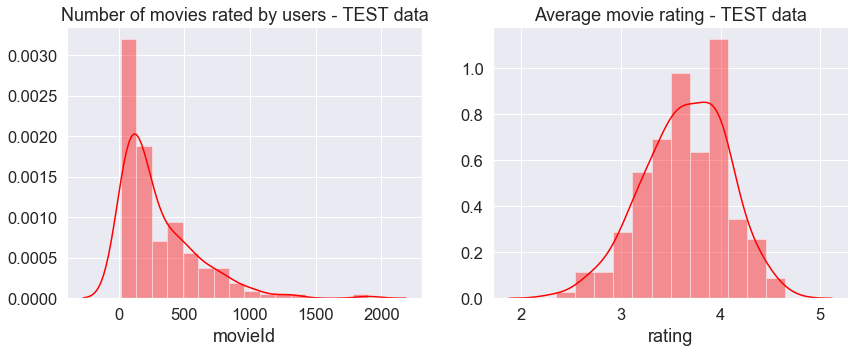

In [7]:
# checking the distributions of number of movies rated by each user and the average rating per user
# in both test and training datasets to see any major differences

train_user_avg = ratings_train.groupby(by='userId', as_index=False).agg({'movieId':'count', 'rating':'mean'})\
                    .reset_index(drop=True)
test_user_avg = ratings_test.groupby(by='userId', as_index=False).agg({'movieId':'count', 'rating':'mean'})\
                    .reset_index(drop=True)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.distplot(train_user_avg['movieId'], color='blue', ax=ax1)\
    .set_title("Number of movies rated by users - TRAINING data")
sns.distplot(train_user_avg['rating'], color='blue', ax=ax2)\
    .set_title("Average movie rating - TRAINING data")

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.distplot(test_user_avg['movieId'], color='red', ax=ax1)\
    .set_title("Number of movies rated by users - TEST data")
sns.distplot(test_user_avg['rating'], color='red', ax=ax2)\
    .set_title("Average movie rating - TEST data")

#### Test & Training datasets look similar
Both the test and training datasets show similar distribution for **number of users per movie and average rating per movie**. This shows that the test and training datsets are not that different and should be good enough for our evaluation. There is difference in the distribution of the average movie rating per user in test and training dataset but these should be okay as we will use adjusted movie ratings for our recommendations.

#### Test dataset - QUERY vs PROBE
Even from the given test dataset, while trying to get the prediction for one user we will only keep some movie ratings away from the model (QUERY movies) while we will pass on the remaining movies from that user to the model to be used as history (PROBE movies). 

This division can be done randomly or temporal basis. We will do this based on time (temporal) - keep most recent ratings from a user as query and the older ones as probe. We can do this based on the timestamps available in the ratings dataset.

In [8]:
# create QUERY and PROBE ratings from test users

ratings_test_query = ratings_test.sort_values(by=['userId', 'timestamp'], ascending=[True, False]).\
                        groupby(by='userId').head(3).reset_index(drop=True)

ratings_test_probe = ratings_test.merge(ratings_test_query[['userId', 'movieId']], \
                                        on=['userId', 'movieId'], how='outer', indicator=True)
ratings_test_probe = ratings_test_probe[ratings_test_probe['_merge'] == 'left_only']
ratings_test_probe = ratings_test_probe.sort_values(by=['userId', 'timestamp'], ascending=[True, False]).\
                        reset_index(drop=True).drop(['_merge'], axis=1)

# add the probe ratings back to the training dataset and keep the query ratings for the test

ratings_train_probe = ratings_train.append(ratings_test_probe)

print "unique users in Test QUERY dataset : ", ratings_test_query['userId'].nunique()
print "#Rows in QUERY, PROBE and Train PROBE datasets : "
print ratings_test_query.shape[0]
print ratings_test_probe.shape[0]
print ratings_train_probe.shape[0]

unique users in Test QUERY dataset :  181
#Rows in QUERY, PROBE and Train PROBE datasets : 
543
54727
263962


In [9]:
ratings_test_query.head()

,userId,movieId,rating,timestamp
0,1015,2410,3.5,1171729506
1,1015,2409,4.0,1171729500
2,1015,1954,4.0,1171729496
3,1588,86882,2.5,1425313598
4,1588,1183,3.0,1421949210


In [10]:
ratings_test_probe.head()

,userId,movieId,rating,timestamp
0,1015,1350,3.0,1169979961
1,1015,8907,3.5,1168879506
2,1015,37727,3.0,1168879464
3,1015,44022,4.0,1168879445
4,1015,1615,4.0,1168879374


In [11]:
ratings_train_probe.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


### II. Algorithm 1. User - User collaborative filtering

The complete algorithm for user user based CBF will be done in the following defined function. Steps for this algo - 

1. create adjusted user movie rating
2. create similarity score for each user with every other user
3. create recommendation for the target user based on the similarity scores

In [18]:
##################
# 1. adjust user ratings for each movie

user_ratings_uu = ratings_train_probe.groupby(by='userId', as_index=False).agg({'rating' : 'mean'}).\
                    reset_index(drop=True)
user_ratings_uu = user_ratings_uu.rename(columns={'rating':'avg_rating'})

ratings_adj_uu = ratings_train_probe.merge(user_ratings_uu, on='userId', how='inner')
ratings_adj_uu['rating_adj'] = ratings_adj_uu['rating'] - ratings_adj_uu['avg_rating']

##################
# 2. create a transformed dataset for user and movieid level to get the adjusted ratings & calculate similarity

ratings_adj_tf_uu = ratings_adj_uu[['userId', 'movieId', 'rating_adj']].\
                    pivot(index='userId', columns='movieId', values='rating_adj').fillna(0)
# similarity matrix - cosine distance
dist_uu = pd.DataFrame(data=cs(ratings_adj_tf_uu), index=ratings_adj_tf_uu.index, columns=ratings_adj_tf_uu.index)

##################
# 3. function to score the movies for a given target user

def movie_reco_uu(user, nbr=30, keep_rated=1):
    
    # get the distance for the target user with every other user
    dist_temp = dist_uu[dist_uu.index == user].sort_values(by = user, axis =1, ascending=False)
    dist_temp = dist_temp.iloc[:,0:nbr+1].transpose().reset_index()
    dist_temp = dist_temp.rename(columns={user:'user_similarity'})
    dist_temp['target_user'] = user
    dist_temp = dist_temp[dist_temp['userId'] != user]
    dist_temp['target_avg_rating'] = user_ratings_uu[user_ratings_uu['userId'] == user]['avg_rating'].iloc[0]
    
    # get the movie ratings for all the userid who are the top neighbors
    dist_temp = dist_temp.merge(ratings_adj_uu[['userId', 'movieId', 'avg_rating', 'rating_adj']],\
                                on='userId', how='inner')
    dist_temp = dist_temp.sort_values(by=['movieId', 'userId']).reset_index(drop=True)
    
    # remove movies that don't have more than 2 users
    movie_users = dist_temp.groupby(by='movieId', as_index=False).agg({'userId':'nunique'}).reset_index(drop=True).\
                    rename(columns={'userId':'user_count'})
    dist_temp = dist_temp.merge(movie_users, on='movieId', how='inner')
    dist_temp = dist_temp[dist_temp['user_count'] > 2]
    dist_temp['score'] = dist_temp['rating_adj'] * dist_temp['user_similarity']
    
    # get the score for each movie
    movie_score = dist_temp.groupby(by='movieId', as_index=False).agg({'score':'sum', 'user_similarity':'sum'})
    movie_score['target_avg_rating'] = user_ratings_uu[user_ratings_uu['userId'] == user]['avg_rating'].iloc[0]
    movie_score['final_score'] = movie_score['target_avg_rating'] + \
                                    (movie_score['score']/movie_score['user_similarity'])
    movie_score = movie_score.sort_values(by='final_score', ascending=False).reset_index(drop=True)
    movie_score = movie_score.merge(movies, on='movieId', how='inner')
    
    # remove the movies which the user has already rated
    if keep_rated == 0:
        movie_already_rated = list(ratings_train_probe[ratings_train_probe['userId'] == user][['movieId']].iloc[:,0])
        movie_score = movie_score[~movie_score['movieId'].isin(movie_already_rated)]
        del movie_already_rated
    
    # delete temp datasets
    del dist_temp
    del movie_users
    
    # return the top relevant movies
    return movie_score[['movieId', 'title', 'genres', 'final_score']]

### III. Algorithm 2 : Item - Item collaborative filtering

The steps for the item - item based CBF will be as follows : 

1. Create adjusted rating for every movie
2. Get similarity scores between every movie
3. rank each movie for a given target user based on a score created using similarity scores between the movie and the top neighbors of the movies (which target user has rated).

In [19]:
#############################
# 1. adjust ratings for each movie user combo
movie_ratings_ii = ratings_train_probe.groupby(by='movieId', as_index=False).agg({'rating' : 'mean'}).\
                    reset_index(drop=True)
movie_ratings_ii = movie_ratings_ii.rename(columns={'rating':'avg_rating'})

ratings_adj_ii = ratings_train_probe.merge(movie_ratings_ii,on='movieId', how='inner')
ratings_adj_ii['rating_adj'] = ratings_adj_ii['rating'] - ratings_adj_ii['avg_rating']

#############################
# 2. create a transformed dataset for user and movieid level to get the adjusted ratings & get similarity scores
ratings_adj_tf_ii = ratings_adj_ii[['userId', 'movieId', 'rating_adj']].\
                    pivot(index='movieId', columns='userId', values='rating_adj').fillna(0)
# similarity matrix - cosine distance
dist_ii = pd.DataFrame(data=cs(ratings_adj_tf_ii), index=ratings_adj_tf_ii.index, columns=ratings_adj_tf_ii.index)

#############################
# 3. user level movie rating averages to be used in the final scoring of the movie

user_rating_ii = ratings_train_probe.groupby(by='userId', as_index=False).agg({'rating':'mean', 'movieId':'count'})\
                .reset_index(drop=True)
user_rating_ii = user_rating_ii.rename(columns={'rating':'avg_user_rating', 'movieId':'rated_movies'})
user_rating_ii = user_rating_ii.sort_values(by='rated_movies', ascending=False).reset_index(drop=True)

#############################
# 4. function to score the movies for a given target user

def movie_reco_ii(user, ngbr=30, keep_rated=1):
    
    #####
    # the seen movies or the rated movies by the user
    movie_already_rated = ratings_adj_ii[ratings_adj_ii['userId'] == user][['movieId', 'rating_adj']]\
                            .reset_index(drop=True)
    N = movie_already_rated.shape[0]
    
    #####
    # the similarity metrics between the seen and unseen movies
    dist_temp = dist_ii.copy()
    dist_temp.reset_index(inplace=True)
    # transform the distance table to long form
    dist_temp = pd.melt(dist_temp, id_vars=['movieId'], value_vars=list(dist_temp.columns)[1:]\
                        , var_name='unseen_movie', value_name='similarity')
    dist_temp = dist_temp.merge(movie_already_rated, on='movieId', how='inner')
    dist_temp = dist_temp.sort_values(by=['unseen_movie', 'similarity'], ascending=[True, False])\
                .reset_index(drop=True)
    # replace the negative similarity with 0
    dist_temp.loc[dist_temp['similarity'] < 0, ['similarity']] = 0
    
    #####
    # Keep top specified neighbors for each unseen movie based on the similarity scores
    if N >= ngbr:
        dist_temp_ngbr = dist_temp.groupby(by='unseen_movie', as_index=False).head(ngbr).reset_index(drop=True)
    else:
        dist_temp_ngbr = dist_temp.groupby(by='unseen_movie', as_index=False).head(N).reset_index(drop=True)
    
    #####
    # calculate the score for each unseen movie
    dist_temp_ngbr['wgt_score'] = dist_temp_ngbr['rating_adj'] * dist_temp_ngbr['similarity']
    movie_scores = dist_temp_ngbr.groupby(by='unseen_movie', as_index=False)\
                    .agg({'wgt_score':'sum', 'similarity':'sum'}).reset_index(drop=True)
    movie_scores['final_score'] = user_rating_ii[user_rating_ii['userId'] == user]['avg_user_rating'].iloc[0] + \
                                (movie_scores['wgt_score']/movie_scores['similarity'])
    movie_scores = movie_scores.sort_values(by='final_score', ascending=False).reset_index(drop=True)
    movie_scores = movie_scores.rename(columns={'unseen_movie':'movieId'})
    
    #####
    # 4. remove the movies already rated by the user
    if keep_rated == 0:
        movie_already_rated = list(ratings_train_probe[ratings_train_probe['userId'] == user][['movieId']].iloc[:,0])
        movie_scores = movie_scores[~movie_scores['movieId'].isin(movie_already_rated)]
        del movie_already_rated
    
    #####
    # 5. get the details of the movies - title, genre
    movie_scores = movie_scores.merge(movies, on='movieId', how='inner')
    
    #####
    # 6. delete temp tables
    del dist_temp
    del dist_temp_ngbr
    
    #####
    # 7. return the scored movie list
    return movie_scores[['movieId', 'title', 'genres', 'final_score']]

### IV. Evaluate the recommendation from both algorithm - RMSE and MAE

Lets loop through all the users in the test query ratings dataset and get the recommendation from both the algorithms. We will then use the predicted ratings for their movies and compare it with their actual rated movies to calculate the RMSE (root mean square error) and MAE (mean absolute error) metrics. The algo with the least RMSE or MAE will be considered better performing.

**Formula for calculating the RMSE -** 

\begin{equation*}
RMSE =  \sqrt{\frac{\sum_{ratings} (P - R)^2}{N}}
\end{equation*}

**Formula for calculating the MAE -** 

\begin{equation*}
MAE =  \frac{\sum_{ratings} |P - R|}{N}
\end{equation*}


where - 
 - P is the predicted rating
 - R is the actual rating
 - N is the count of all ratings
 
We will also calculate the RMSE and MAE from both these algo for **various number of neighbours** to be used in the algo. This can help us identify optimum parameter for the algo as well.

Time to finish : 154.81 mins


Text(0.5,1,'MAE plot for the algos')

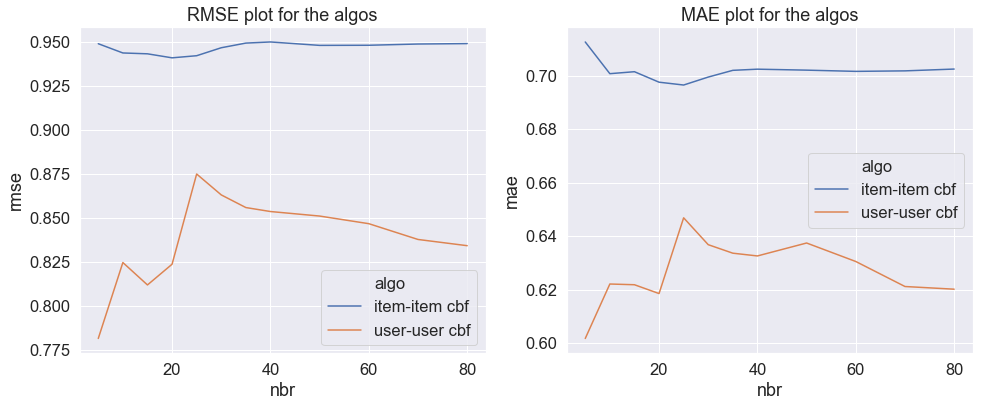

In [23]:
st = time.time()

# calculate the RMSE and MAE by getting predictions for all the ratings in ratings query dataset

reco_eval = pd.DataFrame(columns=['algo', 'nbr', 'userId', 'movieId', 'rating', \
                                      'title', 'genres', 'final_score', 'error_sq', 'error_abs'])

for usr in ratings_test_query['userId'].unique():
    
    usr_query_movies = ratings_test_query[ratings_test_query['userId'] == usr][['userId', 'movieId', 'rating']]\
                    .reset_index(drop=True)
    
    for nbr in [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80]:
        
        # recommendation from user user algo
        reco_uu = movie_reco_uu(usr, nbr, keep_rated=0)
        reco_uu_query = usr_query_movies.merge(reco_uu, on='movieId', how='inner').reset_index(drop=True)
        if reco_uu_query.shape[0] > 0:
            reco_uu_query['error_sq'] = np.square(reco_uu_query['final_score'] - reco_uu_query['rating'])
            reco_uu_query['error_abs'] = np.abs(reco_uu_query['final_score'] - reco_uu_query['rating'])
            reco_uu_query['algo'] = 'user-user cbf'
            reco_uu_query['nbr'] = nbr
            reco_eval = reco_eval.append(reco_uu_query)
        del reco_uu
        del reco_uu_query
        
        # recommendation from item item algo
        reco_ii = movie_reco_ii(usr, nbr, keep_rated=0)
        reco_ii_query = usr_query_movies.merge(reco_ii, on='movieId', how='inner').reset_index(drop=True)
        if reco_ii_query.shape[0] > 0:
            reco_ii_query['error_sq'] = np.square(reco_ii_query['final_score'] - reco_ii_query['rating'])
            reco_ii_query['error_abs'] = np.abs(reco_ii_query['final_score'] - reco_ii_query['rating'])
            reco_ii_query['algo'] = 'item-item cbf'
            reco_ii_query['nbr'] = nbr
            reco_eval = reco_eval.append(reco_ii_query)
        del reco_ii
        del reco_ii_query

reco_eval_summ = reco_eval.groupby(by=['algo', 'nbr'], as_index=False)\
                    .agg({'error_sq':'sum', 'error_abs':'sum', 'movieId':'count'}).reset_index(drop=True)

reco_eval_summ['rmse'] = np.sqrt(1.0*reco_eval_summ['error_sq']/reco_eval_summ['movieId'])
reco_eval_summ['mae'] = 1.0*reco_eval_summ['error_abs']/reco_eval_summ['movieId']

et = time.time()

print "Time to finish :", round((et-st)/60,2), "mins"

# plot the RMSE scores to see which algorithm gave us the least error in prediction and at what #neighbours

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
sns.lineplot(x='nbr', y='rmse', hue='algo', data=reco_eval_summ, ax=ax1).set_title("RMSE plot for the algos")
sns.lineplot(x='nbr', y='mae', hue='algo', data=reco_eval_summ, ax=ax2).set_title("MAE plot for the algos")

### Result : User User algo is the winner!

From the above graph its pretty clear that the User - User algorithm gives much better prediction than Item - Item algorithm. It also looks like that the neighbourhood size of ~20 is good enough in our case for User - User algo. 

We are not choosing the neighburhood size of 5 as it basically gives out very less number of recommendations and is not good enough (See below).

In [33]:
reco_eval_summ[reco_eval_summ['nbr'].isin([5,10,15,20,25])]

,algo,nbr,error_sq,movieId,error_abs,rmse,mae
0,item-item cbf,5,489.039404,543,386.951160,0.949013,0.712617
1,item-item cbf,10,483.644746,543,380.510503,0.943764,0.700756
2,item-item cbf,15,483.149094,543,380.910301,0.943280,0.701492
3,item-item cbf,20,480.815570,543,378.782391,0.940999,0.697573
4,item-item cbf,25,482.042223,543,378.205743,0.942199,0.696511
12,user-user cbf,5,81.272629,133,80.028456,0.781711,0.601718
13,user-user cbf,10,188.447988,277,172.318323,0.824814,0.622088
14,user-user cbf,15,235.440337,357,221.988758,0.812094,0.621817
15,user-user cbf,20,274.206791,404,249.881260,0.823851,0.618518
16,user-user cbf,25,340.749089,445,287.846705,0.875059,0.646847
